In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
file = 'r0.wav'
sig , sr = librosa.load(file,mono=True,sr=None)

In [3]:
print(sr)

44100


In [4]:
hop_length = 1024

Hop length in ms

In [5]:
1024/sr*1000

23.219954648526077

The mel scale is a perceptual scale of pitches judged to be equidistant from one another. The mel and the hertz scale intersect at 1000 Mels/1000 Hz, the divergence outside this point is shown in this plot: https://fi.m.wikipedia.org/wiki/Tiedosto:Mel-Hz_plot.svg

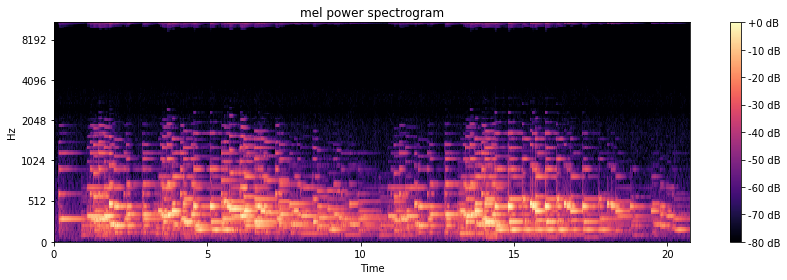

In [6]:
## From librosa demo: http://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y=sig, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

We can decompose the spectrum into harmonic and percussive (non-harmonic) components using median-filtering harmonic percussive source separation (HPSS). When applying a median filter the value of the current chunk of signal is replaced by the median value of its neighbours. When the filter is applied horizontally to a spectrogram (to each frequency bin in each frame), this emphasizes the harmonic components (those frequency components whose amplitude levels are consistent across frames). When the filter is applied vertically (to each frame), this emphasizes the percussive components. See: https://arrow.dit.ie/cgi/viewcontent.cgi?article=1078&context=argcon).

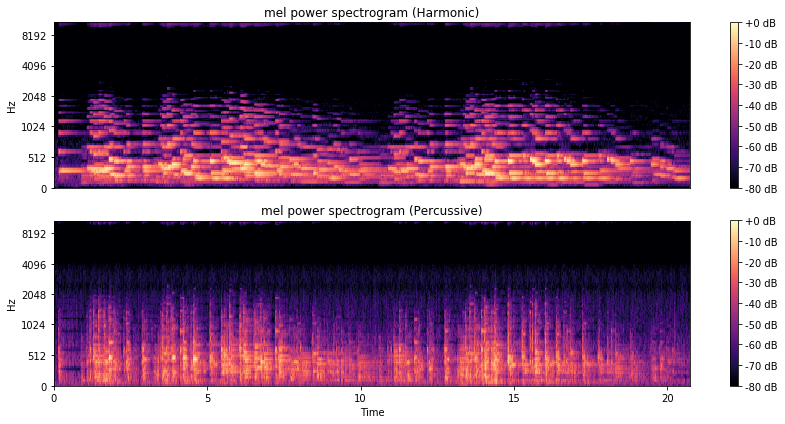

In [7]:
## From librosa demo: http://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

sig_harmonic, sig_percussive = librosa.effects.hpss(sig)

S_harmonic   = librosa.feature.melspectrogram(sig_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(sig_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

Mel-frequency Cepstral Coefficients (MFCCs)

MFCCs provide information about the timbral characteristics of waveform and discard pitch information. Used in speech recognition because they provide a good representation of formants and in music information retrieval for timbre-dependent tasks like genre recognition.

(1) Calculate the Short Time Fourier Transform (STFT, which we covered last class in our discussion of spectrograms)

(2) Convert the spectrum amplitudes to the log scale

(3) Map the log frequencies of the spectrum obtained from the STFT  onto the mel scale, using an overlapping window function to smooth the signal

(4) Take the Discrete Cosine Transform (DCT) of the mel log-amplitudes

The DCT is similar to the discrete Fourier transform (DFT) but differs in that it is real, whereas the DFT is complex. Thus the DCT returns a single coefficient for each frequency with a fixed phase, whereas the DFT returns two coefficients (amplitude and phase) for each frequency. It is useful for compression algorithms because much of the information is collected in the lowest coefficients.

Text(0,0.5,'MFCCs (1:256)')

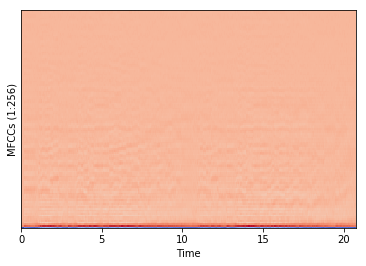

In [8]:
# librosa MFCC function
mfcc = librosa.feature.mfcc(y=sig, sr=sr, hop_length=hop_length, n_mfcc=256)
librosa.display.specshow(mfcc,x_axis='time')
plt.ylabel('MFCCs (1:256)')

Typically only MFCCs 2-13 are used because the 1st coefficient contains pitch-related information, which we want to remove to create pitch-invariant features, and there is a diminishing usefulness of coefficients above 13. The first coeffi

Text(0,0.5,'MFCCs (2:13)')

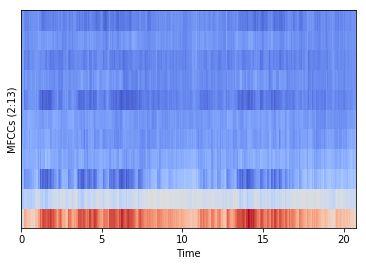

In [9]:
mfcc = librosa.feature.mfcc(y=sig, sr=sr, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(mfcc[1:12,:],x_axis='time')
plt.ylabel('MFCCs (2:13)')

The derivative (or delta) beween MFCCs is a useful feature for observing the stability of timbral information

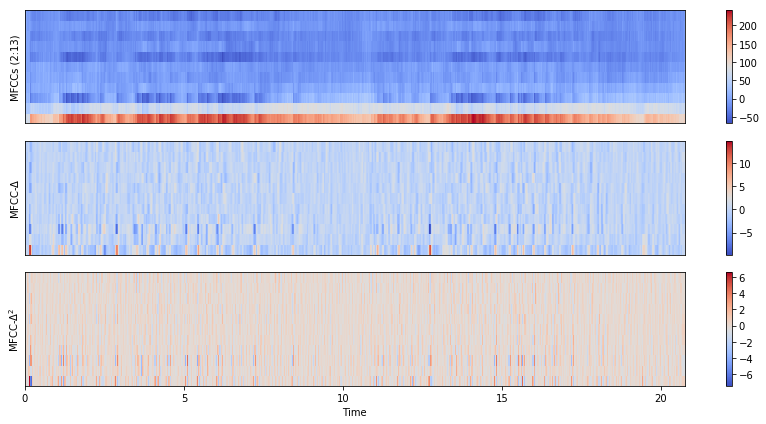

In [10]:
## From librosa demo: http://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc[1:12])
delta2_mfcc = librosa.feature.delta(mfcc[1:12], order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc[1:12])
plt.ylabel('MFCCs (2:13)')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

Chromagrams represent the total energy in each chroma (the 12 pitch class) across the entire spectrum by applying octave equivalency to the frequency bins of a STFT or the output of a filter bank.

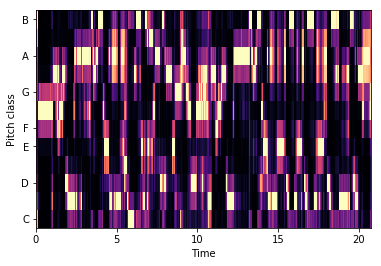

In [11]:
#stft chroma
stftChroma = librosa.feature.chroma_stft(y=sig_harmonic,sr=sr)
librosa.display.specshow(stftChroma, y_axis='chroma', sr=sr,vmin=0.0, vmax=1.0, x_axis='time')

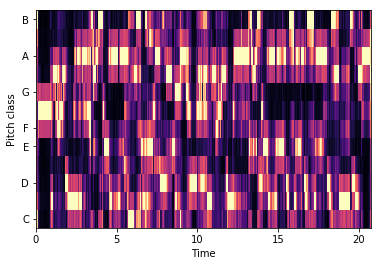

In [12]:
#cqt chroma
cqtChroma = librosa.feature.chroma_cqt(y=sig_harmonic,sr=sr)
librosa.display.specshow(cqtChroma, y_axis='chroma', sr=sr,vmin=0.0, vmax=1.0, x_axis='time')

Chroma Energy Normalized (CENS) are a normalized version of chroma that are useful when making comparisons across audio files. See: https://pdfs.semanticscholar.org/e1dd/06707d33ff9528eafa912d43135cfab47822.pdf

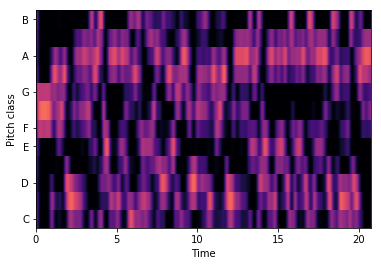

In [13]:
#cens chroma
censChroma = librosa.feature.chroma_cens(y=sig_harmonic,sr=sr)
librosa.display.specshow(censChroma, y_axis='chroma', sr=sr,vmin=0.0, vmax=1.0, x_axis='time')

Other timbral descriptors

From our week 2 reading:
"While theory about timbre is less comprehensive than pitch or loudness, some audio processing tools offer the ability to calculate timbre descriptors that have been found to be meaningful by psychologists. Some descriptors, such as spectral centroid, emerged from the results of psychological tests seeking acoustic correlates of multidimensional scaling embeddings.  These embeddings approximate the results of listening tests where participants were asked to listen to notes from different musical instruments and to rate the similarity between them (Grey, 1977). From related literature, there are a range of descriptors that can be divided into two groups, those that characterise the amount of synchronicity within the spectrum (such as inharmonicity and tonality) and those that describe trends in the distribution of energy in the signal (such as spectral centroid, spectral flatness, spectral flux, spectral roll-off, spectral spread, kurtosis, etc., for details on these descriptors see Peeters et al. (2011))."

Grey, 1977: http://aum.dartmouth.edu/~mcasey/m102/GreyMultidimensionalScaling.pdf
Peters et al. 2011: https://www.mcgill.ca/mpcl/files/mpcl/peeters_2011_jasa.pdf

This website is useful for understanding the specific librosa implementations: https://musicinformationretrieval.com/spectral_features.html

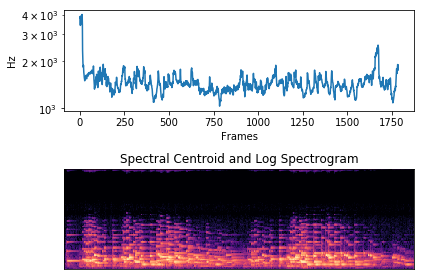

In [14]:
# spectral centroid
specCent=librosa.feature.spectral_centroid(y=sig, sr=sr, n_fft=2048, hop_length=512, freq=None)
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(specCent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xlabel('Frames')
plt.subplot(2, 1, 2)
librosa.display.specshow(log_S)
plt.title('Spectral Centroid and Log Spectrogram')
plt.tight_layout()

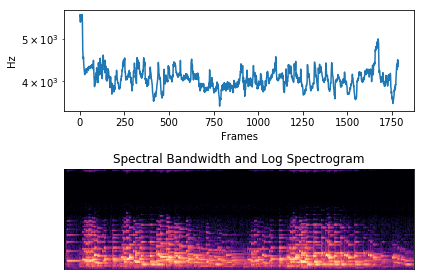

In [15]:
# spectral bandwidth
specBand=librosa.feature.spectral_bandwidth(y=sig, sr=sr, n_fft=2048, hop_length=512, freq=None)
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(specBand.T, label='Spectral bandwidth')
plt.ylabel('Hz')
plt.xlabel('Frames')
plt.subplot(2, 1, 2)
librosa.display.specshow(log_S)
plt.title('Spectral Bandwidth and Log Spectrogram')
plt.tight_layout()

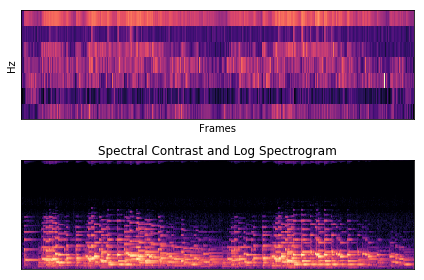

In [16]:
# spectral contrast
specContrast=librosa.feature.spectral_contrast(y=sig, sr=sr, n_fft=2048, hop_length=512, freq=None)
plt.figure()
plt.subplot(2, 1, 1)
librosa.display.specshow(specContrast, label='Spectral contrast')
plt.ylabel('Hz')
plt.xlabel('Frames')
plt.subplot(2, 1, 2)
librosa.display.specshow(log_S)
plt.title('Spectral Contrast and Log Spectrogram')
plt.tight_layout()

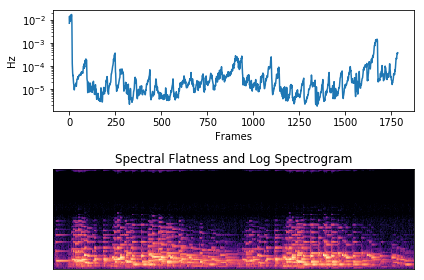

In [17]:
# spectral flatness
specFlatness=librosa.feature.spectral_flatness(y=sig)
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(specFlatness.T, label='Spectral flatness')
plt.ylabel('Hz')
plt.xlabel('Frames')
plt.subplot(2, 1, 2)
librosa.display.specshow(log_S)
plt.title('Spectral Flatness and Log Spectrogram')
plt.tight_layout()

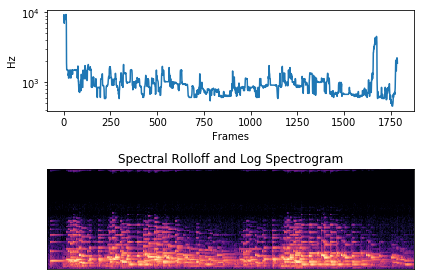

In [18]:
# spectral rolloff
specRolloff=librosa.feature.spectral_rolloff(y=sig, sr=sr)
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(specRolloff.T, label='Spectral rolloff')
plt.ylabel('Hz')
plt.xlabel('Frames')
plt.subplot(2, 1, 2)
librosa.display.specshow(log_S)
plt.title('Spectral Rolloff and Log Spectrogram')
plt.tight_layout()

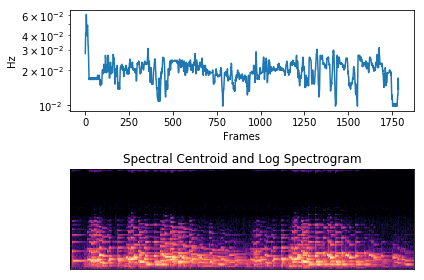

In [19]:
# zero crossing rate
specZeroCross=librosa.feature.zero_crossing_rate(y=sig)
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(specZeroCross.T, label='Spectral zero crossing rate')
plt.ylabel('Hz')
plt.xlabel('Frames')
plt.subplot(2, 1, 2)
librosa.display.specshow(log_S)
plt.title('Spectral Centroid and Log Spectrogram')
plt.tight_layout()